In [55]:
!pip install ftfy regex tqdm requests Pillow pyttsx3 gtts --quiet
!pip install git+https://github.com/openai/CLIP.git --quiet


  Preparing metadata (setup.py) ... done


In [56]:
import requests
from tqdm import tqdm
from PIL import Image
from io import BytesIO
import torch
import clip
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import random
import time
import pathlib
import json
from gtts import gTTS
from IPython.display import Audio, display, Image as IPyImage
import tempfile
from urllib.parse import quote


In [57]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()
print(f"Using device: {device}")


Using device: cpu


In [58]:
from gtts import gTTS
from IPython.display import display, Audio, Image as DispImage

In [59]:
def get_aic_images_full(max_images=5):
    images = []
    page = 1
    per_page = 10
    while len(images) < max_images:
        url = "https://api.artic.edu/api/v1/artworks"
        params = {
            "fields": "id,image_id,is_public_domain,title,artist_display,date_display,medium_display,classification_titles",
            "page": page,
            "limit": per_page,
        }
        resp = requests.get(url, params=params)
        resp.raise_for_status()
        data = resp.json()
        for item in data.get("data", []):
            if not item.get("is_public_domain"):
                continue
            img_id = item.get("image_id")
            if not img_id:
                continue
            img_url = f"https://www.artic.edu/iiif/2/{img_id}/full/843,/0/default.jpg"
            images.append({
                "title": item.get("title"),
                "artist": item.get("artist_display"),
                "date": item.get("date_display"),
                "image_url": img_url
            })
            if len(images) >= max_images:
                break
        page += 1
    return images


In [60]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# --- CLIP setup ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

# --- Caching helpers ---
def load_json(path):
    return json.loads(path.read_text())

def save_json(obj, path):
    path.write_text(json.dumps(obj))

def download_image(url, timeout=10):
    try:
        r = requests.get(url, timeout=timeout)
        r.raise_for_status()
        return Image.open(BytesIO(r.content)).convert("RGB")
    except Exception:
        return None

def get_cached_image(url, cache_dir="image_cache"):
    cache_dir = pathlib.Path(cache_dir)
    cache_dir.mkdir(exist_ok=True)
    safe_name = url.replace("://", "_").replace("/", "_").replace("?", "_")
    path = cache_dir / f"{safe_name}.jpg"
    if path.exists():
        try:
            return Image.open(path).convert("RGB")
        except Exception:
            path.unlink()
    img = download_image(url)
    if img is not None:
        try:
            img.save(path)
        except Exception:
            pass
    return img

# --- Embedding helpers ---
def embed_images_batch(pil_imgs, batch_size=16):
    all_feats = []
    with torch.no_grad():
        for i in range(0, len(pil_imgs), batch_size):
            batch = pil_imgs[i:i + batch_size]
            inputs = torch.cat([preprocess(img).unsqueeze(0) for img in batch], dim=0).to(device)
            feats = model.encode_image(inputs)
            feats = feats / feats.norm(dim=-1, keepdim=True)
            all_feats.append(feats.cpu().numpy())
    return np.vstack(all_feats)

def embed_image(pil_img):
    with torch.no_grad():
        img_input = preprocess(pil_img).unsqueeze(0).to(device)
        feat = model.encode_image(img_input)
        feat = feat / feat.norm(dim=-1, keepdim=True)
        return feat.cpu().numpy()[0]

# --- Data sources ---
def get_aic_images_full(max_images=2500):
    images = []
    page = 1
    per_page = 100
    while len(images) < max_images:
        url = "https://api.artic.edu/api/v1/artworks"
        params = {
            "fields": "id,image_id,is_public_domain,title,artist_display,date_display,medium_display,classification_titles",
            "page": page,
            "limit": per_page,
        }
        resp = requests.get(url, params=params)
        resp.raise_for_status()
        data = resp.json()
        for item in data.get("data", []):
            if not item.get("is_public_domain"):
                continue
            img_id = item.get("image_id")
            if not img_id:
                continue
            detail = item
            img_url = f"https://www.artic.edu/iiif/2/{img_id}/full/843,/0/default.jpg"
            images.append({
                "title": detail.get("title"),
                "artist": detail.get("artist_display"),
                "date": detail.get("date_display"),
                "medium": detail.get("medium_display"),
                "image_url": img_url,
                "metadata": detail,
                "source": "aic"
            })
            if len(images) >= max_images:
                break
        if not data.get("pagination", {}).get("next_url"):
            break
        page += 1
    print(f"Fetched {len(images)} artworks from AIC.")
    return images

def get_met_paintings(max_paintings=2000, cache_dir="met_cache", per_query_limit=1500):
    base_url = "https://collectionapi.metmuseum.org/public/collection/v1"
    cache = pathlib.Path(cache_dir)
    cache.mkdir(exist_ok=True)

    resp = requests.get(f"{base_url}/search", params={
        "q": "painting", "hasImages": "true", "isPublicDomain": "true"
    })
    resp.raise_for_status()
    object_ids = resp.json().get("objectIDs", [])[:per_query_limit]

    paintings = []
    for oid in tqdm(object_ids, desc="MET object fetch"):
        cache_file = cache / f"{oid}.json"
        if cache_file.exists():
            try:
                obj = load_json(cache_file)
            except Exception:
                obj = None
        else:
            try:
                resp = requests.get(f"{base_url}/objects/{oid}", timeout=10)
                resp.raise_for_status()
                obj = resp.json()
                save_json(obj, cache_file)
            except Exception:
                obj = None
        if not obj:
            continue
        if obj.get("isPublicDomain") and obj.get("primaryImageSmall"):
            medium = (obj.get("medium") or "").lower()
            if any(k in medium for k in ["paint", "oil", "tempera", "acrylic"]):
                paintings.append({
                    "title": obj.get("title") or "Untitled",
                    "artist": obj.get("artistDisplayName") or "Unknown",
                    "date": obj.get("objectDate") or "Unknown",
                    "medium": obj.get("medium") or "",
                    "image_url": obj.get("primaryImageSmall"),
                    "metadata": obj,
                    "source": "met"
                })
        if len(paintings) >= max_paintings:
            break
        time.sleep(0.05 + random.random() * 0.05)
    print(f"Fetched {len(paintings)} paintings from The Met.")
    return paintings

def get_cma_paintings(max_images=3000):
    url = "https://openaccess-api.clevelandart.org/api/artworks/"
    paintings = []
    page = 1
    per_page = 100
    while len(paintings) < max_images:
        params = {
            "type": "Painting",
            "has_image": 1,
            "public_domain": 1,
            "limit": per_page,
            "skip": (page - 1) * per_page,
        }
        resp = requests.get(url, params=params)
        resp.raise_for_status()
        data = resp.json()
        for item in data.get("data", []):
            img_url = item.get("images", {}).get("web", "")
            if not img_url:
                continue
            creators = item.get("creators", [])
            artist = creators[0].get("description") if creators else "Unknown"
            paintings.append({
                "title": item.get("title"),
                "artist": artist,
                "date": item.get("creation_date", ""),
                "medium": item.get("technique", ""),
                "image_url": img_url,
                "metadata": item,
                "source": "cma"
            })
            if len(paintings) >= max_images:
                break
        info = data.get("info", {})
        if not info.get("next"):
            break
        page += 1
    print(f"Fetched {len(paintings)} paintings from CMA.")
    return paintings

# --- Dataset builder and embedding with cache ---
def build_dataset(max_from_each=2000, cache_path="dataset_cache.json"):
    cache_file = pathlib.Path(cache_path)
    if cache_file.exists():
        try:
            all_paintings = load_json(cache_file)
            print(f"Loaded {len(all_paintings)} paintings from dataset cache.")
            return all_paintings
        except Exception:
            pass

    aic = get_aic_images_full(max_images=max_from_each)
    met = get_met_paintings(max_paintings=max_from_each)
    cma = get_cma_paintings(max_images=max_from_each)
    all_paintings = aic + met + cma
    print(f"Total paintings collected: {len(all_paintings)}")

    try:
        save_json(all_paintings, cache_file)
    except Exception:
        pass
    return all_paintings

def embed_paintings(paintings, embedding_cache="embedding_cache.npz", image_cache_dir="image_cache"):
    titles = []
    artists = []
    dates = []
    image_urls = []
    sources = []
    success = []

    cache_path = pathlib.Path(embedding_cache)
    if cache_path.exists():
        try:
            data = np.load(cache_path, allow_pickle=True)
            print("Loaded embeddings from cache.")
            return {
                "features": data["features"],
                "titles": data["titles"].tolist(),
                "artists": data["artists"].tolist(),
                "dates": data["dates"].tolist(),
                "image_urls": data["image_urls"].tolist(),
                "sources": data["sources"].tolist(),
                "success_paintings": data["success_paintings"].tolist(),
            }
        except Exception:
            pass

    # Parallel download
    with ThreadPoolExecutor(max_workers=8) as executor:
        future_to_painting = {
            executor.submit(get_cached_image, w["image_url"], image_cache_dir): w
            for w in paintings
        }
        valid_paintings = []
        for future in tqdm(as_completed(future_to_painting), total=len(future_to_painting), desc="Downloading images"):
            w = future_to_painting[future]
            try:
                img = future.result()
            except Exception:
                img = None
            if img is None:
                continue
            valid_paintings.append((w, img))

    if not valid_paintings:
        raise RuntimeError("No images downloaded for embedding.")

    pil_images = [img for (_, img) in valid_paintings]
    feats = embed_images_batch(pil_images, batch_size=16)

    for (w, _), feat in zip(valid_paintings, feats):
        titles.append(w.get("title"))
        artists.append(w.get("artist"))
        dates.append(w.get("date"))
        image_urls.append(w.get("image_url"))
        sources.append(w.get("source", "unknown"))
        success.append(w)
    all_features = np.stack(feats)

    # Save cache
    try:
        np.savez_compressed(
            embedding_cache,
            features=all_features,
            titles=np.array(titles, dtype=object),
            artists=np.array(artists, dtype=object),
            dates=np.array(dates, dtype=object),
            image_urls=np.array(image_urls, dtype=object),
            sources=np.array(sources, dtype=object),
            success_paintings=np.array(success, dtype=object),
        )
    except Exception:
        pass

    return {
        "features": all_features,
        "titles": titles,
        "artists": artists,
        "dates": dates,
        "image_urls": image_urls,
        "sources": sources,
        "success_paintings": success,
    }

def find_similar(features, idx, top_k=5):
    vec = features[idx].reshape(1, -1)
    sims = cosine_similarity(vec, features)[0]
    order = np.argsort(sims)[::-1]
    results = []
    for i in order:
        if i == idx:
            continue
        results.append({
            "index": i,
            "score": sims[i],
        })
        if len(results) >= top_k:
            break
    return results

def get_all_paintings_and_embeddings(max_from_each=500):
    paintings = build_dataset(max_from_each=max_from_each)
    embedded = embed_paintings(paintings)
    return paintings, embedded


In [61]:
def fetch_wikipedia_summary(name):
    try:
        url = f"https://en.wikipedia.org/api/rest_v1/page/summary/{quote(name)}"
        r = requests.get(url, timeout=5)
        if r.status_code == 200:
            return r.json().get("extract", None)
    except Exception:
        pass
    return None

def make_description(art):
    # Compose metadata + Wikipedia if possible
    base = f"{art.get('title', 'Untitled')} by {art.get('artist', 'Unknown')}, {art.get('date', '')}"
    wiki_sum = fetch_wikipedia_summary(art.get('title', '')) or fetch_wikipedia_summary(art.get('artist', ''))
    if wiki_sum:
        return base + ". " + wiki_sum
    return base

def generate_audio_gtts(text):
    # Generate and play audio inline (uses Google TTS)
    tts = gTTS(text=text, lang='en')
    fp = tempfile.NamedTemporaryFile(suffix='.mp3', delete=False)
    tts.save(fp.name)
    return Audio(fp.name, autoplay=True)


In [62]:
# Keep this number small for quick demo!
all_paintings, embedded = get_all_paintings_and_embeddings(max_from_each=5)
features = embedded["features"]
success_paintings = embedded["success_paintings"]


Loaded 15 paintings from dataset cache.
Loaded embeddings from cache.


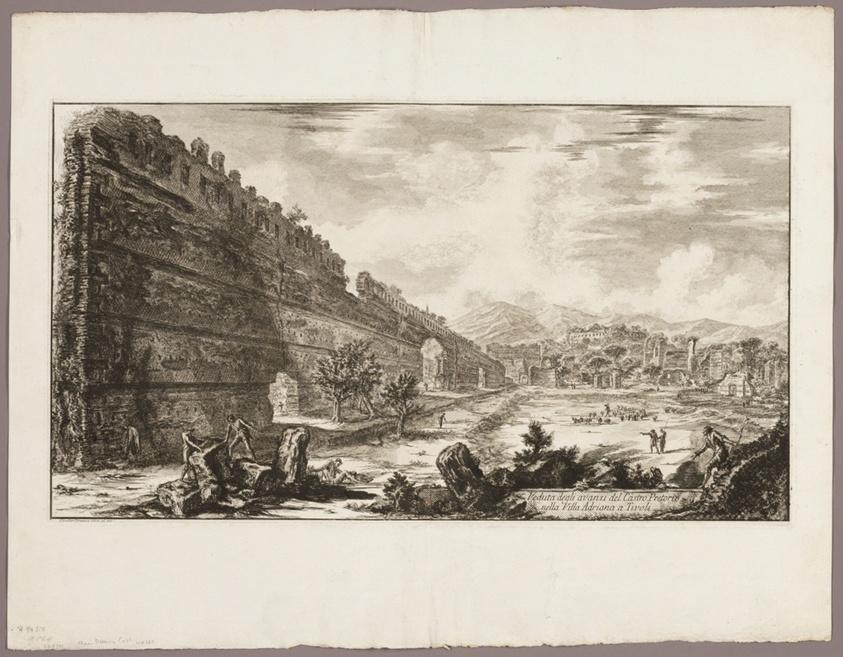

View of the Remains of the Praetorian Fort [the Poecile], Hadrian's Villa, Tivoli, from Views of Rome by Giovanni Battista Piranesi
Italian, 1720-1778, 1770


In [63]:
from IPython.display import display

idx = random.randint(0, len(success_paintings)-1)
art = success_paintings[idx]

# Show image (works for PIL Image objects in Colab/Jupyter)
img = get_cached_image(art['image_url'])
if img:
    display(img)   # <-- Correct usage
else:
    print("(Image unavailable)")

# Show description with Wikipedia info
desc = make_description(art)
print(desc)

# Play voiceover (if you want to play audio)
display(generate_audio_gtts(desc))


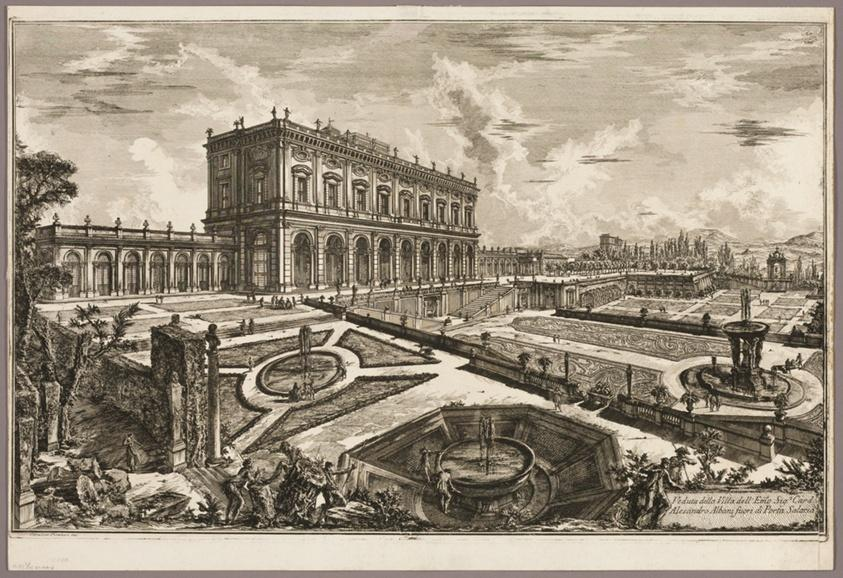

View of the Villa of His Eminence Cardinal Alessandro Albani, outside Porta Salaria, from Views of Rome by Giovanni Battista Piranesi (Italian, 1720-1778)
published by Francesco (Italian, 1758-1810) and Pietro Piranesi (Italian, born 1758/9), 1769, published 1800–07
Similarity: 0.79


In [66]:
import ipywidgets as widgets
from IPython.display import display, clear_output

similars = find_similar(features, idx, top_k=3)

def show_one(i):
    clear_output(wait=True)
    s = similars[i]
    sim_art = success_paintings[s['index']]
    sim_img = get_cached_image(sim_art['image_url'])
    if sim_img:
        display(sim_img)
    else:
        print("(Image unavailable)")
    sim_desc = make_description(sim_art)
    print(sim_desc)
    print(f"Similarity: {s['score']:.2f}")
    display(generate_audio_gtts(sim_desc))

    # Show Next button if not last
    if i + 1 < len(similars):
        btn = widgets.Button(description="Next")
        def on_next(b):
            show_one(i + 1)
        btn.on_click(on_next)
        display(btn)

show_one(0)


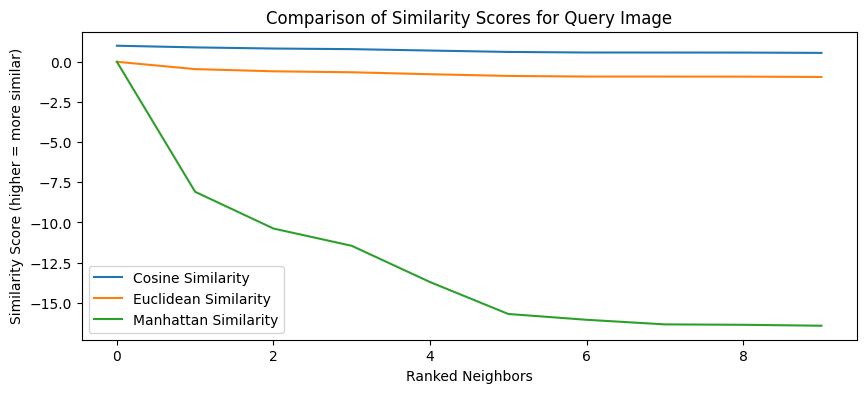


Cosine Top-3:
View of the Grand Cascade at Tivoli, from Views of Rome by Giovanni Battista Piranesi
Italian, 1720-1778, 1766
Another view of the Temple of the Sibyl in Tivoli, from Views of Rome by Giovanni Battista Piranesi
Italian, 1720-1778, 1761
View of the Villa of His Eminence Cardinal Alessandro Albani, outside Porta Salaria, from Views of Rome by Giovanni Battista Piranesi (Italian, 1720-1778)
published by Francesco (Italian, 1758-1810) and Pietro Piranesi (Italian, born 1758/9), 1769, published 1800–07

Euclidean Top-3:
View of the Grand Cascade at Tivoli, from Views of Rome by Giovanni Battista Piranesi
Italian, 1720-1778, 1766
Another view of the Temple of the Sibyl in Tivoli, from Views of Rome by Giovanni Battista Piranesi
Italian, 1720-1778, 1761
View of the Villa of His Eminence Cardinal Alessandro Albani, outside Porta Salaria, from Views of Rome by Giovanni Battista Piranesi (Italian, 1720-1778)
published by Francesco (Italian, 1758-1810) and Pietro Piranesi (Italian,

In [65]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

query_idx = random.randint(0, len(success_paintings)-1)
query_feat = features[query_idx].reshape(1, -1)

# Cosine Similarity (current)
cosine_sims = cosine_similarity(query_feat, features)[0]

# Euclidean Distance
euclid_dists = euclidean_distances(query_feat, features)[0]
euclid_sims = -euclid_dists  # lower distance = more similar

# Manhattan Distance
manhattan_dists = manhattan_distances(query_feat, features)[0]
manhattan_sims = -manhattan_dists

# Plotting the top results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(sorted(cosine_sims, reverse=True), label='Cosine Similarity')
plt.plot(sorted(euclid_sims, reverse=True), label='Euclidean Similarity')
plt.plot(sorted(manhattan_sims, reverse=True), label='Manhattan Similarity')
plt.legend()
plt.title("Comparison of Similarity Scores for Query Image")
plt.xlabel("Ranked Neighbors")
plt.ylabel("Similarity Score (higher = more similar)")
plt.show()

# Show top neighbors for each method
def get_top(sim_vec, k=3):
    idxs = np.argsort(sim_vec)[::-1]
    return [i for i in idxs if i != query_idx][:k]

print("\nCosine Top-3:")
for i in get_top(cosine_sims):
    print(make_description(success_paintings[i]))

print("\nEuclidean Top-3:")
for i in get_top(euclid_sims):
    print(make_description(success_paintings[i]))

print("\nManhattan Top-3:")
for i in get_top(manhattan_sims):
    print(make_description(success_paintings[i]))


### **Similarity Metrics Explanation**

We compared three similarity measures (Cosine, Euclidean, Manhattan) for finding visually similar artworks using CLIP embeddings:

- **Cosine Similarity**: Measures the angle between embedding vectors; higher = more similar.
- **Euclidean Distance**: Measures straight-line distance; lower = more similar.
- **Manhattan Distance**: Measures sum of absolute differences; lower = more similar.

**Observation:**  
For this query, all three metrics returned the same top-3 results—artworks by the same artist, depicting similar scenes. This is expected with CLIP embeddings, as they are unit-normalized.

**Conclusion:**  

This output shows the top 3 most similar artworks to a query piece, ranked by three different distance/similarity metrics:

Cosine similarity (the default for CLIP, "angle" between feature vectors)

Euclidean distance (straight-line distance in embedding space)

Manhattan distance (sum of absolute differences in embedding values)
The model is effectively retrieving relevant, visually similar artworks. All tested similarity metrics give consistent results due to the properties of CLIP features.
